# How To Identify Customer Segmentation
**Using RFM Analysis**

Angewandte Programmierung, sonst. Beteiligung (25%)

This notebook aims at analyzing the content of a real E-Commerce database that lists purchases made by  ∼ 25,500 customers over a period from November 2018 to April 2019. Based on this analysis, I develop a RFM model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase

# Table of Contents
- [Introduction](#intro)

- [Step l: Data Importing and Cleaning](#s1)
- [Step 2: Create RFM Anaylses for each customers](#s2)
- [Step 3: Calculate RFM score and level](#s3)
- [Step 4: Visualize the RFM Result](#s4)
- [Step 5: K-Means Clustering Algorithm on RFM](#s4)
- [Conclusion](#conc)

 <img src="imgs/segmentation.jpg" width=300 height=300 style="float:left" />

<a id='intro'></a>

# Introduction 


**What is RFM?**

RFM (Recency Frequency Monetary) analysis or RFM segmentation is an effective marketing technique to identify your best customers. Instead of reaching out to 100% of your audience, target only specific customer segments that can prove beneficial for your business in future. 

**Recency (R) – How often do they purchase?**

Deduct most recent purchase date from today to calculate the recency value. 1, 14 or 500 days ago?

**Frequency (F) – How often do they purchase?**

For example, if someone placed 10 orders over a period of time, their frequency is 10.

**Monetary (M) – How much do they spend?**

Simply total up the money from all transactions to get the M value.

Customers with the most recent purchase, more transactions and spending more money are assigned higher values.

<img src="imgs/RFM.png" width=300 height=300 style="float:left"/>


<a id='s1'></a>

# 1. Data Importing and Cleaning

### i. Import liberaries

In [615]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from datetime import datetime

### ii. Load data into a dataframe

In [616]:
df = pd.read_csv('e-commerce.csv')
string_to_date = lambda x : datetime.strptime(x, "%d/%m/%Y").date()

# Convert InvoiceDate from object to datetime format
df['day'] = df['day'].apply(string_to_date)
df['day'] = df['day'].astype('datetime64[ns]')

# Drop NA values
df.dropna()

# Print DataFrame
df.head()

,product_title,product_type,variant_title,variant_sku,variant_id,customer_id,order_id,day,net_quantity,gross_sales,discounts,returns,net_sales,taxes,total_sales,returned_item_quantity,ordered_item_quantity
0,DPR,DPR,100,AD-982-708-895-F-6C894FB,52039657,1312378,83290718932496,2018-12-04,2,200.0,-200.00,0.00,0.0,0.0,0.0,0,2
1,RJF,Product P,28 / A / MTM,83-490-E49-8C8-8-3B100BC,56914686,3715657,36253792848113,2019-04-01,2,190.0,-190.00,0.00,0.0,0.0,0.0,0,2
2,CLH,Product B,32 / B / FtO,68-ECA-BC7-3B2-A-E73DE1B,24064862,9533448,73094559597229,2018-11-05,0,164.8,-156.56,-8.24,0.0,0.0,0.0,-2,2
3,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,53616575668264,2019-02-19,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1
4,NMA,Product F,40 / B / FtO,6C-1F1-226-1B3-2-3542B41,43823868,4121004,29263220319421,2019-02-19,1,119.0,-119.00,0.00,0.0,0.0,0.0,0,1


### iii. Data Summary

In [617]:
# Let’s take a closer look at the data we will need to manipulate.
print('{:,} rows; {:,} columns'.format(df.shape[0], df.shape[1]))
print('Transactions timeframe from {} to {}'.format(df['day'].min(), df['day'].max()))
print('{:,} transactions don\'t have a customer id'.format(df[df.customer_id.isnull()].shape[0]))
print('{:,} unique customer_id'.format(len(df.customer_id.unique())))


70,052 rows; 17 columns
Transactions timeframe from 2018-11-01 00:00:00 to 2019-04-30 00:00:00
0 transactions don't have a customer id
25,543 unique customer_id


<a id='s2'></a>
# 2. Create RFM analysis for each customers

### i. Calculate Recency, Frequency and Monetary

The first we need to do is to sort customers based on recency, frequency, and monetary values.
To calculate recency, we will be taking one day after the last invoice date of our data set as the snapshot date ‘2019-04-30’.
The date difference will give us how recent the last transaction was made.With that, we can then group our dateframe by customer_id and assign it to ‘df_RFM’ for our data pre-processing.

In [618]:
# Convert string to date
max_date = df['day'].max().date()

Recency = lambda x : (max_date - x.max().date()).days
Frequency  = lambda x: len(x.unique())
Monetary = lambda x : round(sum(x), 2)

df_RFM = df.groupby('customer_id').agg({'day': Recency,
                                        'order_id': Frequency,  
                                        'gross_sales': Monetary })

# Rename the columns of DataFrame
df_RFM.columns = ['Recency', 'Frequency', 'Monetary']

# Descending Sorting 
df_RFM = df_RFM.sort_values('Monetary', ascending=False)

# Print DataFrame
print(df_RFM.head())
print('{:,} rows; {:,} columns'.format(df_RFM.shape[0], df_RFM.shape[1]))

             Recency  Frequency  Monetary
customer_id                              
8325158            4         17   2812.58
2028611           98         17   2661.72
6578818            5         16   2486.73
7843272            0         20   2325.06
8032770           50         13   2065.88
25,543 rows; 3 columns


### ii. Plot RFM distributions

Great, we have 25543 customer records grouped by recency of their purchase, the frequency by their quantity, and the monetary value of the purchases. Now we can get into the meat of things and use the .qcut() method to assign the relative percentile to their RFM features. But before that, let’s examine the distribution of our Recency, Frequency, and Monetary.

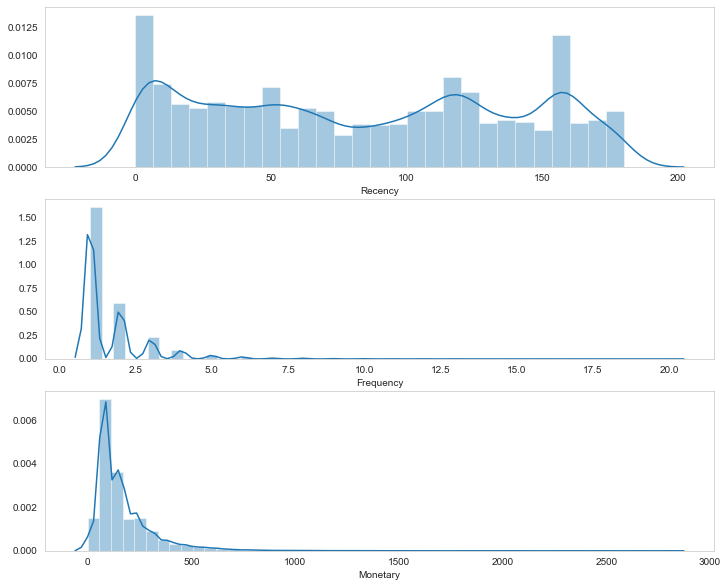

In [619]:
plt.figure(figsize=(12,10))# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(df_RFM['Recency'])# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(df_RFM['Frequency'])# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(df_RFM['Monetary'])# Show the plot
plt.show()

This plot provides us with some very interesting insights and how skewed our data is. The important thing to take note here is that we will be grouping these values in quantiles.

### iii. Calculate RFM quartiles

Now we’ll group the customers based on RFM values. Cause these are continuous values, we can also use the quantile values and divide them into 4 groups. We create a 4 labels for our f_labels, where 4 is the “best” quantile. We do the same for our f_label. We then create new columns “R” and “F” and assign the r_group and f_group values to them respectively.

Next, we do the same for our monetary value by grouping the values into 4 quantiles using .qcut() method.


In [620]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5); m_labels = range(1, 5)

# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)

# Assign these labels to 4 equal percentile groups 
f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

# Create new columns R and F 
df_RFM = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
8325158,4,17,2812.58,4,4,4
2028611,98,17,2661.72,2,4,4
6578818,5,16,2486.73,4,4,4
7843272,0,20,2325.06,4,4,4
8032770,50,13,2065.88,3,4,4


Finally, with these 3 scores in place, R, F, and M, we can create our first RFM segment by concatenating the values together below.

### iv. Concat RFM quartile values to create RFM Segments

In [621]:
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
df_RFM['RFM_Segment'] = df_RFM.apply(join_rfm, axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment
customer_id,,,,,,,
8325158,4,17,2812.58,4,4,4,444
2028611,98,17,2661.72,2,4,4,244
6578818,5,16,2486.73,4,4,4,444
7843272,0,20,2325.06,4,4,4,444
8032770,50,13,2065.88,3,4,4,344


From the output, you can see that we have our concatenated segments ready to be used for our segmentation, but there is one issue…

### v. Count num of unique segments

In [622]:
rfm_count_unique = df_RFM.groupby('RFM_Segment')['RFM_Segment'].nunique()
print(rfm_count_unique.sum())

48


Having 48 different segments using the concatenate method quickly becomes unwieldy for any practical use. We will need a more concise way to define our segments.

<a id='s3'></a>

### vi. Calculate RFM score and level 

**Summing the Score**: One of the most straightforward methods is to sum our scores to a single number and define RFM levels for each score range.

In [623]:
# Calculate RFM_Score
df_RFM['RFM_Score'] = df_RFM[['R','F','M']].sum(axis=1)
df_RFM.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_id,,,,,,,,
8325158,4,17,2812.58,4,4,4,444,12.0
2028611,98,17,2661.72,2,4,4,244,10.0
6578818,5,16,2486.73,4,4,4,444,12.0
7843272,0,20,2325.06,4,4,4,444,12.0
8032770,50,13,2065.88,3,4,4,344,11.0


We can get creative and hypothesize about what each score range entails, but for this exercise I will take inspiration from some common segment names.

# 3. Doing Manual Segmentation 

### i. Categorizing customers

Finally categorize customers into 8 categories ‘STARS’, ‘NEW’, ‘BIG SPENDER’, ‘LOYAL’, ‘ACTIVE’, ‘LOST’, ‘LIGHT’ and ‘REGULARS’

In [625]:
def rfm_level(df):
    if df['RFM_Segment'] == '444':
        return 'STARS'
    
    elif df['RFM_Segment'] == '411':
        return 'NEW'
    
    else:     
        if df['M'] == 4:
            return 'BIG SPENDER'
        
        elif df['F'] == 4:
            return 'LOYAL'
        
        elif df['R'] == 4:
            return 'ACTIVE'
        
        elif df['R'] == 1:
            return 'LOST'
        
        elif df['M'] == 1:
            return 'LIGHT'
        
        return 'REGULARS'
       
# Create a new column RFM_Level
df_RFM['RFM_Level'] = df_RFM.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
df_RFM[::2000]

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_id,,,,,,,,,
8325158,4,17,2812.58,4,4,4,444,12.0,STARS
4193770,0,5,380.85,4,4,4,444,12.0,STARS
4597386,2,2,270.82,4,3,4,434,11.0,BIG SPENDER
3382250,131,2,222.52,2,3,4,234,9.0,BIG SPENDER
6258536,107,3,172.50,2,4,3,243,9.0,LOYAL
7214317,125,1,156.67,2,1,3,213,6.0,REGULARS
6860385,4,2,148.32,4,4,3,443,11.0,LOYAL
7792319,124,1,106.67,2,1,2,212,5.0,REGULARS
1586258,147,1,82.50,1,1,2,112,4.0,LOST


### ii. Number of  segments

In [627]:
df_RFM['RFM_Level'].value_counts()

LOST           5303
REGULARS       4855
BIG SPENDER    4691
LIGHT          3226
ACTIVE         3024
LOYAL          2749
STARS          1695
Name: RFM_Level, dtype: int64

<a id='s4'></a>

### iii. Calculate mean values for each segment


In [544]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg = df_RFM.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg.columns = rfm_agg.columns.droplevel()
rfm_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg['Percent'] = round((rfm_agg['Count']/rfm_agg.Count.sum())*100, 2)

# Reset the index
rfm_agg = rfm_agg.reset_index()

# Print the aggregated dataset
rfm_agg

,RFM_Level,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,ACTIVE,13.0,1.0,108.0,3024,11.84
1,BIG SPENDER,76.0,3.0,335.0,4691,18.37
2,LIGHT,90.0,1.0,60.0,3226,12.63
3,LOST,158.0,1.0,91.0,5303,20.76
4,LOYAL,71.0,2.0,140.0,2749,10.76
5,REGULARS,84.0,1.0,122.0,4855,19.01
6,STARS,12.0,4.0,456.0,1695,6.64


## i. Treemap (RFM)

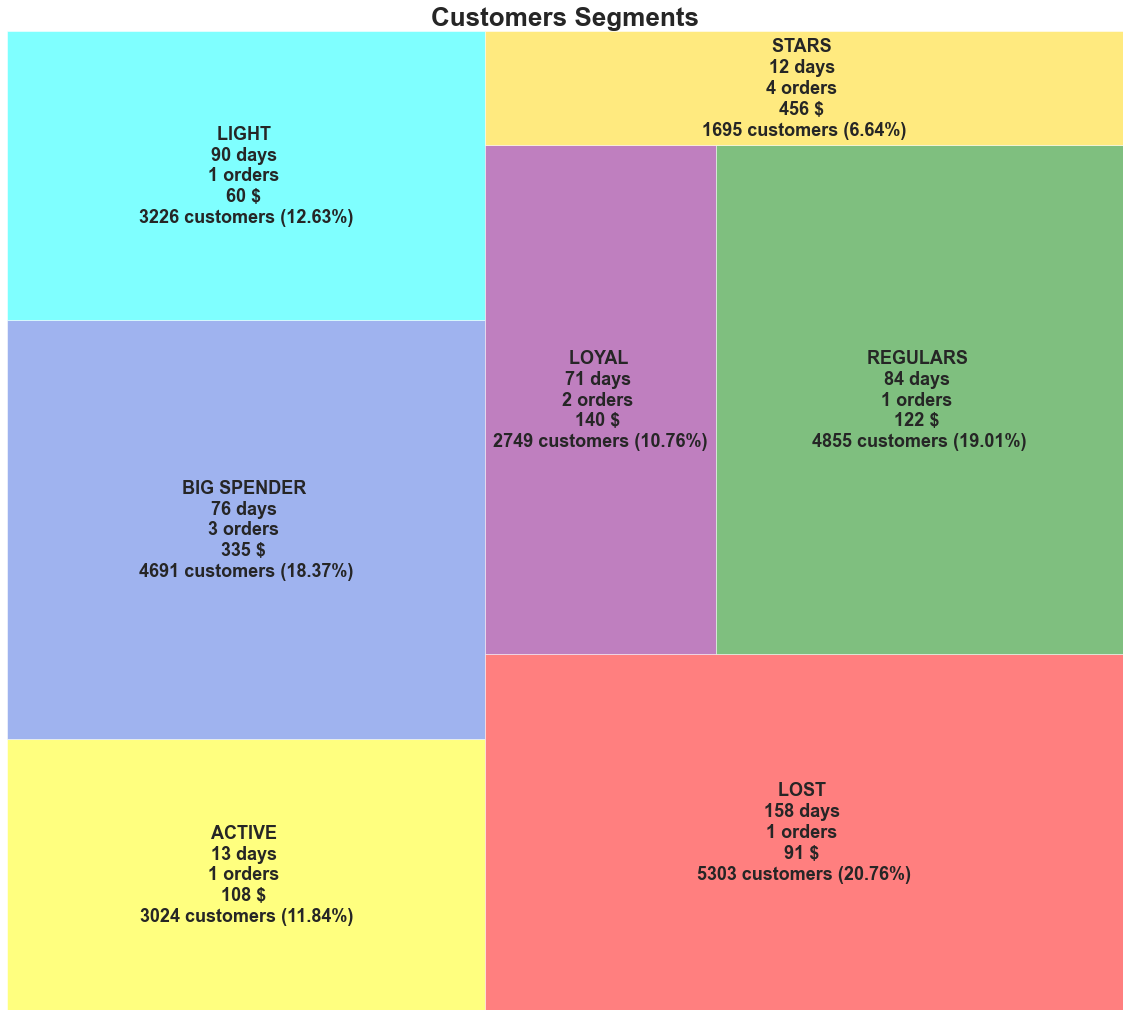

In [594]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 18)

colors_dict = {'ACTIVE':'yellow','BIG SPENDER':'royalblue', 'LIGHT':'cyan',
               'LOST':'red', 'LOYAL':'purple', 'POTENTIAL':'green', 'STARS':'gold'}

squarify.plot(sizes=rfm_agg['Count'],
              text_kwargs={'fontsize':18,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg.iloc[i])
                      for i in range(0, len(rfm_agg))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('imgs/RFM Segments.png')
plt.show()

## ii. Scatter Plot  (RFM)

In [546]:
import plotly.express as px

fig = px.scatter(rfm_agg, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="RFM_Level",
           hover_name="RFM_Level", size_max=100)

fig.show()

# iii. 3d Scatter Plot (RFM)

In [593]:
import plotly.express as px

fig = px.scatter_3d(df_RFM, x='Recency', y='Frequency', z='Monetary',
                    color = 'RFM_Level', opacity=0.5,
                    color_discrete_map = colors_dict)
#fig.show()
fig.update_traces(marker=dict(size=5),
                  
                  selector=dict(mode='markers'))
# tight layout
fig.show()

<tbody>
<tr>
<td>New Subscribers</td>
<td>These are identifiable customers who very recently joined your email marketing list, but haven’t purchased yet.</td>
</tr>
<tr>
<td>Window Shoppers</td>
<td>These are identifiable customers who have never purchased but are spending time browsing product detail pages.</td>
</tr>
<tr>
<td>Hot Prospects</td>
<td>These are potential customers with the highest levels of purchase intent. They are adding to cart, potentially abandoning transactions, and appear to be ready to buy.</td>
</tr>
<tr>
<td>Champions</td>
<td>There are your most loyal customers. They are your big spenders, purchase the most frequently, and have very high recency.</td>
</tr>
<tr>
<td>Regulars</td>
<td>These are great customers who purchase regularly and frequently. They are on their way to becoming Champions.</td>
</tr>
<tr>
<td>Potential Regulars</td>
<td>These are customers who have purchased recently, more than once, and are on their way to becoming better customers.</td>
</tr>
<tr>
<td>New Customers</td>
<td>These are new customers who have purchased recently, but only once.</td>
</tr>
<tr>
<td>Promising</td>
<td>These are also new customers who have purchased recently but spent a little bit more or more than once in a short period of time.</td>
</tr>
<tr>
<td>Cooling Down</td>
<td>These customers were once Regulars or Champions, but have decelerated their purchasing activity. This group needs attention.</td>
</tr>
<tr>
<td>At Risk</td>
<td>These are customers with above average recency, frequency, and monetary characteristics but are well past the point of abnormal purchase recency. You don’t have much time left to re-engage these folks.</td>
</tr>
<tr>
<td>Highly at Risk</td>
<td>These are formerly high-value customers who are in the final stage of defection. If we don’t market to them now, it’s likely that we’ll lose these customers forever.</td>
</tr>
<tr>
<td>Lost/Ignore</td>
<td>These are customers with low frequency, low recency and low monetary scores. Don’t invest marketing resources or attention here.</td>
</tr>
</tbody>

In [548]:
df_RFM

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_id,,,,,,,,,
8325158,4,17,2812.58,4,4,4,444,12.0,STARS
2028611,98,17,2661.72,2,4,4,244,10.0,BIG SPENDER
6578818,5,16,2486.73,4,4,4,444,12.0,STARS
7843272,0,20,2325.06,4,4,4,444,12.0,STARS
8032770,50,13,2065.88,3,4,4,344,11.0,BIG SPENDER
...,...,...,...,...,...,...,...,...,...
4745717,167,1,0.00,1,3,1,131,5.0,LOST
4766692,169,1,0.00,1,3,1,131,5.0,LOST
4767380,179,1,0.00,1,3,1,131,5.0,LOST


In [549]:
df100 = df_RFM[['Recency','Frequency','Monetary']]
df100

,Recency,Frequency,Monetary
customer_id,,,
8325158,4,17,2812.58
2028611,98,17,2661.72
6578818,5,16,2486.73
7843272,0,20,2325.06
8032770,50,13,2065.88
...,...,...,...
4745717,167,1,0.00
4766692,169,1,0.00
4767380,179,1,0.00


### Assessing the optimal number of clusters with the Elbow Method

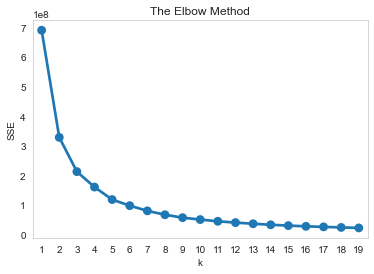

In [597]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df100)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [587]:
model = KMeans(n_clusters=5, random_state=42)
model.fit(df100)
model.labels_.shape

(25543,)

In [588]:
df100["Cluster"] = model.labels_
df100.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

<ipython-input-588-6cdfa98db4a1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0        136.81      1.14    90.30  10203
1         44.34      4.18   535.61   1504
2         29.53      7.69  1125.21    189
3         65.91      2.42   272.79   5362
4         39.00      1.32   111.69   8285

In [589]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_agg2 = df100.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(0)

rfm_agg2.columns = rfm_agg2.columns.droplevel()
rfm_agg2.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
rfm_agg2['Percent'] = round((rfm_agg2['Count']/rfm_agg2.Count.sum())*100, 2)

# Reset the index
rfm_agg2 = rfm_agg2.reset_index()

# Change thr Cluster Columns Datatype into discrete values
rfm_agg2['Cluster'] = 'Cluster '+ rfm_agg2['Cluster'].astype('str')

# Print the aggregated dataset
rfm_agg2

,Cluster,RecencyMean,FrequencyMean,MonetaryMean,Count,Percent
0,Cluster 0,137.0,1.0,90.0,10203,39.94
1,Cluster 1,44.0,4.0,536.0,1504,5.89
2,Cluster 2,30.0,8.0,1125.0,189,0.74
3,Cluster 3,66.0,2.0,273.0,5362,20.99
4,Cluster 4,39.0,1.0,112.0,8285,32.44


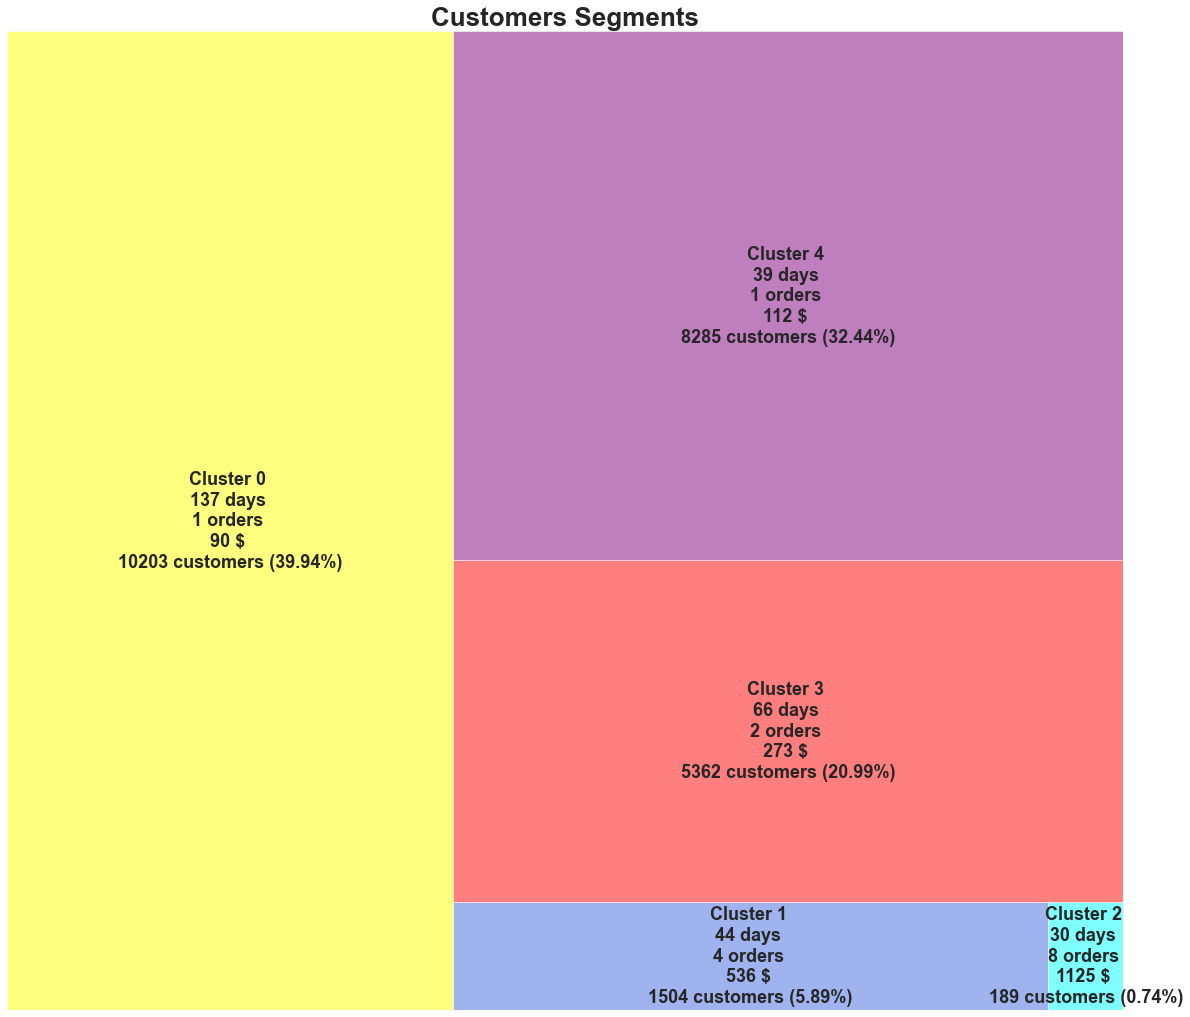

In [590]:
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(20, 18)

colors_dict2 = {'Cluster0':'yellow','Cluster1':'royalblue', 'Cluster2':'cyan',
               'Cluster3':'red', 'Cluster4':'purple', 'Cluster5':'green', 'Cluster6':'gold'}

squarify.plot(sizes=rfm_agg2['Count'],
              text_kwargs={'fontsize':18,'weight':'bold', 'fontname':"sans serif"},
              color=colors_dict2.values(),
              label=['{} \n{:.0f} days \n{:.0f} orders \n{:.0f} $ \n{:.0f} customers ({}%)'.format(*rfm_agg2.iloc[i])
                      for i in range(0, len(rfm_agg2))], alpha=0.5 )


plt.title("Customers Segments",fontsize=26,fontweight="bold")
plt.axis('off')

plt.savefig('imgs/Unsupervised Segments.png')
plt.show()

In [591]:
import plotly.express as px

fig = px.scatter_3d(rfm_agg2, x='RecencyMean', y='FrequencyMean', z='MonetaryMean',
                    color = 'Cluster', opacity=0.3)
#fig.show()
fig.update_traces(marker=dict(size=20),
                  
                  selector=dict(mode='markers'))
# tight layout
fig.show()

In [592]:
import plotly.express as px

fig = px.scatter(rfm_agg2, x="RecencyMean", y="MonetaryMean", size="FrequencyMean", color="Cluster",
           hover_name="Cluster", size_max=100)

fig.show()

<a id='conc'></a>

# Conclusion

From here, we can see that a large percentage (~60%) of our customers are in the top tier RFM levels. The store must be doing something right to be maintaining their loyalty!

The other 40% will need some work. Let’s explore using some ads to re-target them:
1. **Champons Customers**: Bought recently, buy often and spend the most!
2. **Can’t Lose Them**: Made biggest purchases, and often. But haven’t returned for a long time. 	
1. **Loyal Customers**: Spend good money with us often. Responsive to promotions.
1. **Potential**: Recent customers, but spent a good amount and bought more than once.
2. **Promising**: Recent shoppers, but haven’t spent much.	
3. **Moving Away**: made some initial purchase but have not seen them since. Was it a bad customer experience? Or product-market fit? Let’s spend some resource build our brand awareness with them.
4. **Require Activation**: Poorest performers of our RFM model. They might have went with our competitors for now and will require a different activation strategy to win them back.

THE 11 POSSIBLE SEGMENTS AND ACTIONS
1. Champions - Reward them. Ask them for reviews. They can be early adopters for new products.

2. Loyal Customers - Up-sell higher value products. Ask for reviews. Ask for referrals, Engage with them; send them free gifts, pizzas, hand-written cards etc.

3. Promising - Offer subscription and loyalty programs. Provide recommendations. Ask for reviews. Send gifts, handwritten cards, etc. Make one-on-one personalized phone calls.

4. New Customers - Provide post-sale support. Give them early success, offer free gift cards. Start a one-on-one relationship.

5. Abandoned Checkouts - Provide pre-sale support. Start building a relationship. Learn their wants/needs.

6. Warm Leads - Reach out personally and provide proactive support. Learn about them and build a relationship.

7. Cold Leads - Reach out personally through email or SMS to revive interest. Learn about their passion/problem.

8. Need Attention - Make limited time offers. Recommend new products or services based on past purchases. Try to re-sell or cross-sell.

9. Shouldn't Lose - Win back through special offers. Talk to them, survey them, don't lose them to competitors.

10. Sleepers - Send personal emails and messages to reconnect. Provide helpful resources.

11. Lost - Try to revive interest with reach-out campaign, otherwise ignore.
